## Exploratory Data Analysis

1. Exploring the data
2. Missing Values
3. Numerical Discrete Variables
4. Numerical Continuous Variables
5. Categorical Variables and their cardinality
6. Outliers
7. Correlation Plot/Matrix
8. Feature Importance (check for unnecessary features like id features)
9. Statistical Tests to check for relationship amoung features
9. Other Plots (combinations of 2 or more features with respect to target)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

In [6]:
df = pd.read_csv('bengaluru_house_prices.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### Step 1 : Exploring the dataset

* There are 13320 records and 9 features.

In [7]:
df.shape

(13320, 9)

* General information about the data. We can see that the df has some missing values.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


* Show same descriptive statistisc about each feature.

In [9]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


### 2. Missing Values

This function return True if there is any missing values in data, otherwise returns False. It also creates a csv file with the amount and percentage of missing values for each feature

In [10]:
def check_for_missing_values(dataset):
    
    if dataset.isna().sum().any():

        df_nan_values = pd.DataFrame()

        for col in dataset.columns:
            nr_nan_values_percentage = dataset[col].isna().mean() * 100
            nr_nan_values = dataset[col].isna().sum()

            if nr_nan_values > 0:
                row = {'Feature' : col, 
                       'Percentage Nan Values' : nr_nan_values_percentage, 
                       'Amount Nan Values' : nr_nan_values}
                df_nan_values = df_nan_values.append(row, ignore_index=True)


        df_nan_values.to_csv('missing_values_info.csv', index=False)
        
        return True
    
    else:
        return False

In [11]:
if check_for_missing_values(df):
    print('There are missing values')
else:
    print('There are no missing values')

There are missing values


In [12]:
# show information about missing values in each column
pd.read_csv('missing_values_info.csv')

,Feature,Percentage Nan Values,Amount Nan Values
0,location,0.007508,1.0
1,size,0.120120,16.0
2,society,41.306306,5502.0
3,bath,0.548048,73.0
4,balcony,4.572072,609.0


We can use seaborn to create a simple heatmap to see where we are missing data!

<AxesSubplot:>

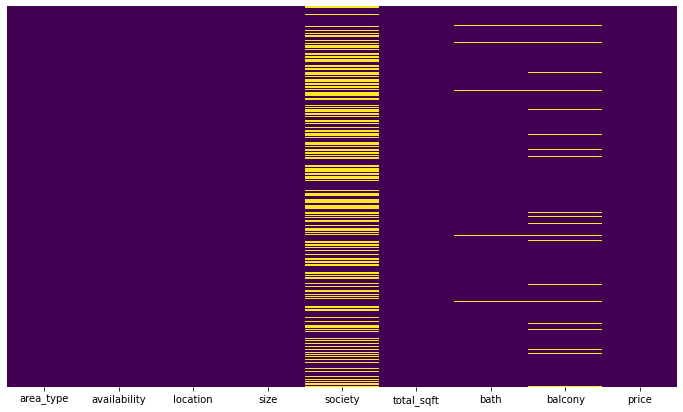

In [13]:
plt.figure(figsize=(12,7))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**Since society has many missing values, we need to find the relationship between missing values and Price.**

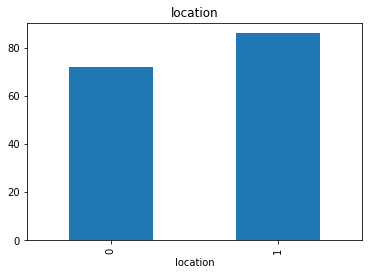

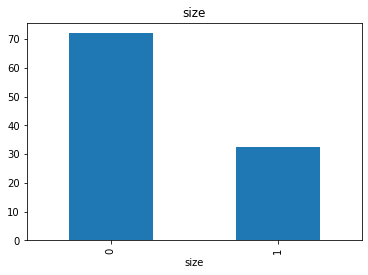

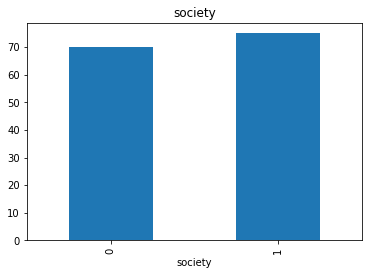

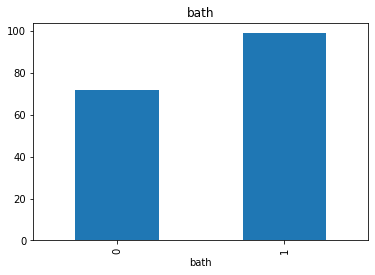

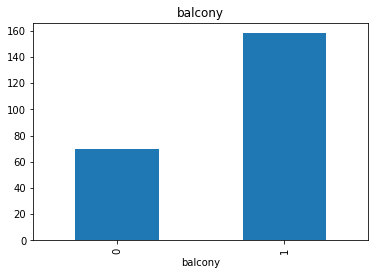

In [14]:
features_with_na=[features for features in df.columns if df[features].isnull().sum()>0]


i = 1
for feature in features_with_na:
    data = df.copy()
    
    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    
    # let's calculate the mean SalePrice where the information is missing or present
    
    #plt.subplot(4,4, i)
    i = i + 1
    data.groupby(feature)['price'].median().plot.bar()
    plt.title(feature)
    plt.show()

### 3. Numerical Discrete Variables

I am going to convert some numerical features that have object datatype into float.

In [15]:
# convert total_sqft to numerical

def convert_sqft_to_num(x):

    try:
        float_x = float(x) # case where x is of type '234.3' which means we can directly covert to float
        return float_x
        
    except:
        
        tokens = x.split('-') 
        if len(tokens) == 2:
            return (float(tokens[0])+float(tokens[1]))/2  # tokens are in string format so we must convert to float to calculate mean
         # else(cases where we dont have a range min-max the length of tokens = 1 since those values do not contain '-')
        tokens = x.split(' ') 
        if len(tokens) == 2: # cases '132Sq. Yards' or '716Sq. Meter'
            if tokens[1] == 'Yards':  # case '132Sq. Yards'  
                yards = float(tokens[0][:-3])
                sqft = yards / 0.11111111
                return sqft
            elif tokens[1] == 'Meter':  # case '716Sq. Meter'
                meters = float(tokens[0][:-3])
                sqft = meters / 0.09290304
                return sqft
    
        else:  # cases '6Acres', '24Guntha', '3Cents', '1Grounds'
            if 'Acres' in x:
                tokens = x.split('Acres')
                acres = float(tokens[0])
                sqft = acres / 0.00002296
                return sqft
        
            elif 'Guntha' in x:
                tokens = x.split('Guntha')
                guntha = float(tokens[0])
                sqft = guntha / 0.00000003587
                return sqft
        
            elif 'Cents' in x:
                tokens = x.split('Cents')
                cents = float(tokens[0])
                sqft = cents / 0.0023
                return sqft
        
            elif 'Grounds' in x:
                tokens = x.split('Grounds')
                grounds = float(tokens[0])
                sqft = grounds / 0.00041666666666667
                return sqft
    
    
        return None

In [16]:
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

In [17]:
# convert size to numerical
df['size'] = df['size'].fillna(df['size'].mode()[0])
df['size'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

In [18]:
# Numerical Features
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O' and feature not in ['RowID']]

print('Number of numerical variables: ', len(numerical_features))
print(numerical_features)

Number of numerical variables:  5
['size', 'total_sqft', 'bath', 'balcony', 'price']


In [19]:
# Numerical Discrete Features
# I will denote a dicrete feature if it has less than 25 different numerical values

discrete_features=[feature for feature in numerical_features if len(df[feature].unique())<25]
print("Discrete Variables Count: {}".format(len(discrete_features)))
print(discrete_features)

Discrete Variables Count: 3
['size', 'bath', 'balcony']


Show the distribution of discrete features using Count Plot

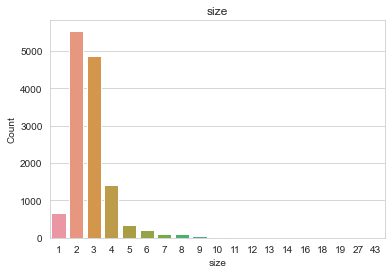

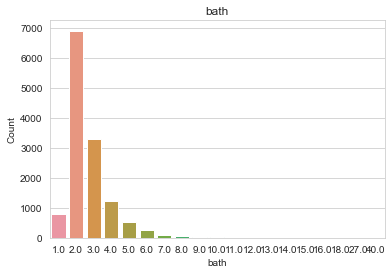

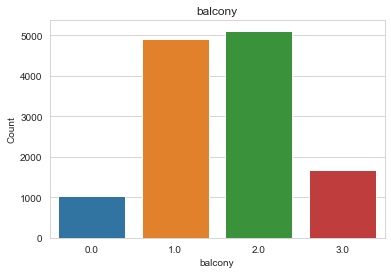

In [20]:
sns.set_style('whitegrid')

for feature in discrete_features:
    data=df.copy()
    
    sns.countplot(x=feature, data=data)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

Show the relationship between discrete feature and target feature Price. If price has many outliers we use the median as a value that represents the price column since median is not affected by outliers, otherwise mean. Price feature has a lot of outliers so based on Percentile and IQR approach (boxplot) so i will use median to represent the price column.

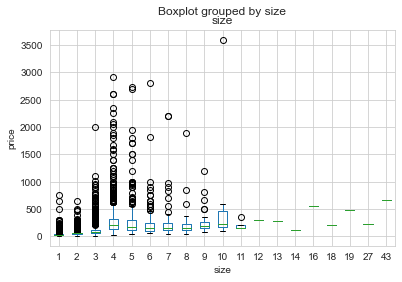

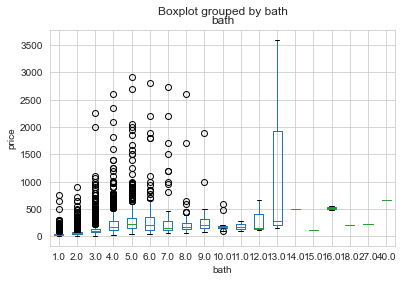

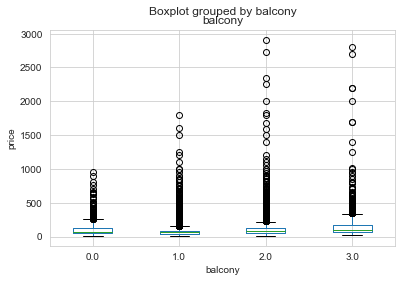

In [21]:
for feature in discrete_features:
    data=df.copy()
    data.boxplot(column='price', by=feature)
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

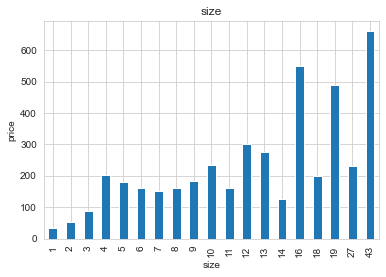

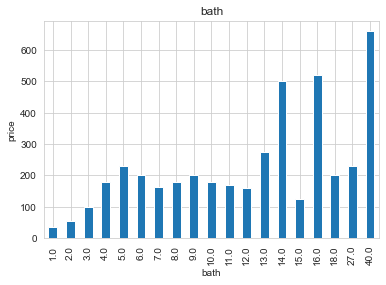

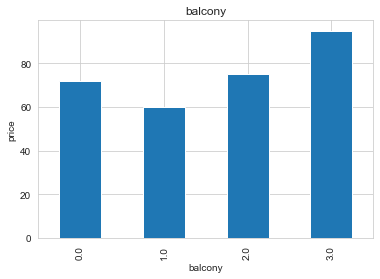

In [22]:
for feature in discrete_features:
    data=df.copy()
    data.groupby(feature)['price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

### Step 4 : Numerical Continuous Features

In [23]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_features]
print("Continuous feature Count {}".format(len(continuous_feature)))
print(continuous_feature)

Continuous feature Count 2
['total_sqft', 'price']


Show the distribution of continous features using Histogram/DistPlot and Boxplot/Violinplot.

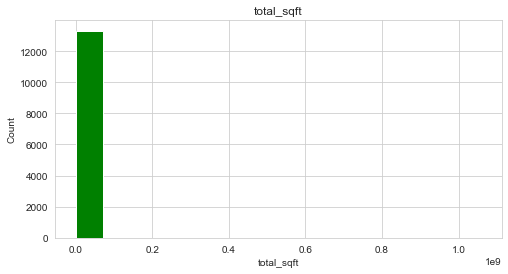

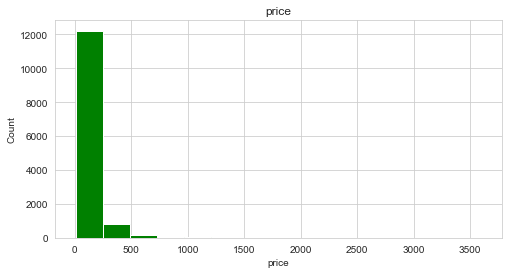

In [24]:
for feature in continuous_feature:
    data=df.copy()
    data[feature].hist(color='green',bins=15,figsize=(8,4)) 
    #sns.distplot(df[feature], kde=True,color='darkred',bins=40) # df[feature].dropna() to drop nan values
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

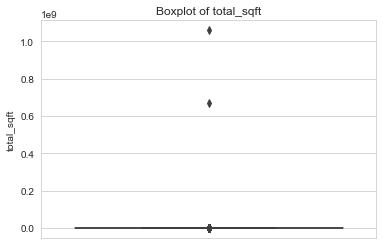

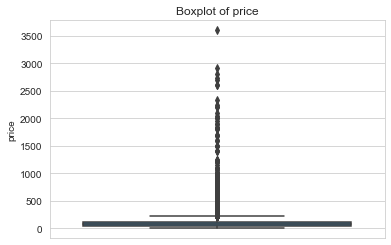

In [27]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(y=feature, data=data)
    plt.ylabel(feature)
    plt.title(f'Boxplot of {feature}')
    plt.show()

 Show relationship between continous feature and target feature.

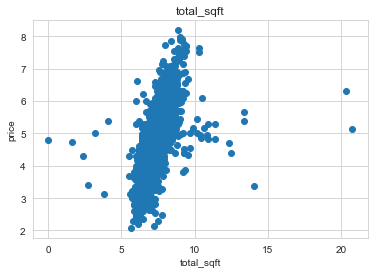

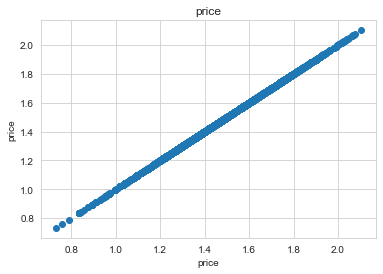

In [26]:
for feature in continuous_feature:
    data=df.copy()
    if 0 in data[feature].unique():
        data[feature] = data[feature] + 1
    else:
        data[feature]=np.log(data[feature])
        data['price']=np.log(data['price'])
        plt.scatter(data[feature],data['price'])
        plt.xlabel(feature)
        plt.ylabel('price')
        plt.title(feature)
        plt.show()

### Step 6 : Categorical features

In [64]:
categorical_features=[feature for feature in df.columns if df[feature].dtypes=='O' and feature not in ['Name']]
print(len(categorical_features))
print(categorical_features)

4
['area_type', 'availability', 'location', 'society']


In [65]:
# show for categorical feature its cardinality (amount of unique categories)
for feature in categorical_features:
    print(f'Feature {feature} - Number of Categories {len(df[feature].unique())}')

Feature area_type - Number of Categories 4
Feature availability - Number of Categories 81
Feature location - Number of Categories 1306
Feature society - Number of Categories 2689


Show the distribution of categorical features using CountPlot. We can not plot all the categories of features with huge cardinality. So I will plot only the frequencies/counts of top k most frequent categories.

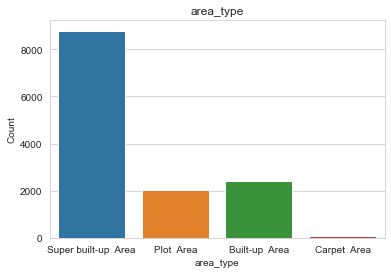

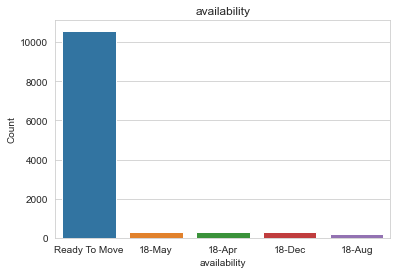

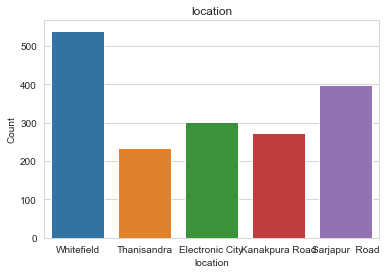

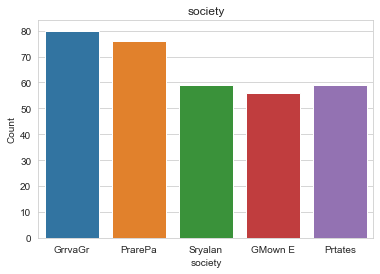

In [67]:
for feature in categorical_features:
    data=df.copy()  
    
    cardinality = len(df[feature].unique())
    if cardinality > 10:
        top_categories = df[feature].value_counts().sort_values(ascending=False).head(5).index
        top = df[feature][df[feature].isin(top_categories)]      
        sns.countplot(x=top, data=data)
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.title(feature)
        plt.show()
        
    else:    
        sns.countplot(x=feature, data=data)
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.title(feature)
        plt.show()

Find out the relationship between categorical variable and dependent feature price.

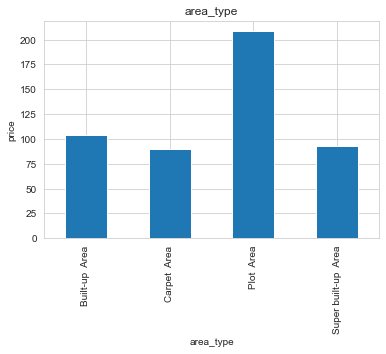

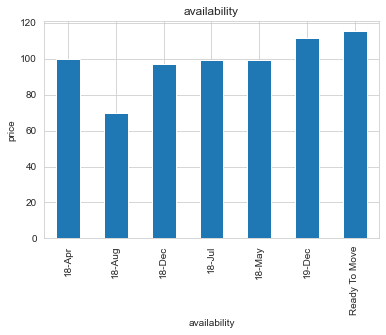

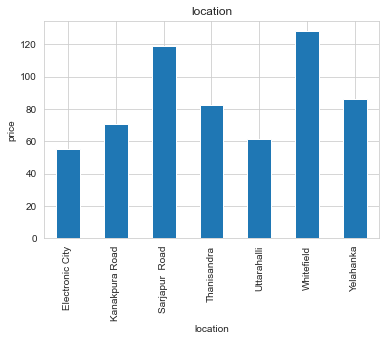

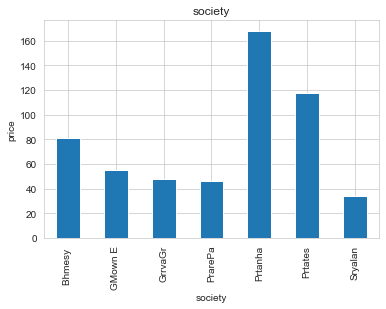

In [69]:
for feature in categorical_features:
    data=df.copy()
    
    cardinality = len(df[feature].unique())
    if cardinality < 10:
        data.groupby(feature)['price'].mean().plot.bar()
        plt.xlabel(feature)
        plt.ylabel('price')
        plt.title(feature)
        plt.show()
        
    else:
        top_categories = df[feature].value_counts().sort_values(ascending=False).head(7).index
        top = df[feature][df[feature].isin(top_categories)]
        data.groupby(top)['price'].mean().plot.bar()
        plt.xlabel(feature)
        plt.ylabel('price')
        plt.title(feature)
        plt.show()

### Step 5 : Outliers

* If feature is normally distributed we use every value that is higher than mean + 3std or lower than mean - 3std is an outlier. If feature does not follow Normal Distribution every value that is higher than 75% percentile + 1.5IQR or lower than 25% - 1.5IQR where IQR = 75% percentile - 25% percentile, is considered as an outlier (using boxplots).
* From the histograms of continuos features we saw that they dont follow the Normal Distribution so I am going to use Boxplot to detect outliers.

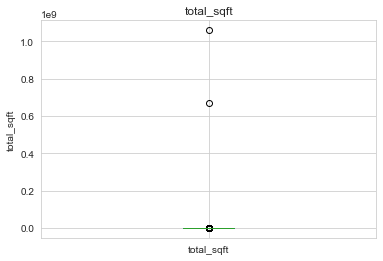

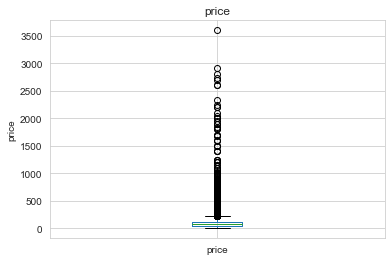

In [70]:
for feature in continuous_feature:
    data=df.copy()
    if 0 in data[feature].unique():
        data[feature] = data[feature] + 1
    
    #data[feature]=np.log(data[feature])
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

### Step 6 : Other Plots